# Submission

## load package

In [1]:
import sys
import pandas as pd

from keras.applications import xception
from keras.applications import resnet50
from keras.applications import mobilenetv2
# from efficientnet import EfficientNetB3

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
from keras.preprocessing import image

from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import gc


Using TensorFlow backend.


In [2]:
bKaggle = True
datadir = './pre/'
modeldir = './pre/'
inputdir='./'
if bKaggle:
    datadir = '../input/carmodel5/ppcarmodel/'
    modeldir = '../input/carmodel6/model/'
    inputdir = '../input/2019-3rd-ml-month-with-kakr/'

print(modeldir)

../input/carmodel6/model/


In [3]:
# 224/299
imagesize=250
# get_ipython().run_line_magic('matplotlib', 'inline')

def dbgprint(msg):
    if bKaggle:
        os.system('echo "'+msg+'"')
    else:
        print(msg)

dbgprint('hello log')

In [4]:
# f1 score 
def new_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Predict

In [19]:
# test data load for submission
# dftrain = pd.read_csv(inputdir+'train.csv')
# dftrain['class'] = dftrain['class'].astype('str')
# dftest = dftrain.iloc[8000:,:]

dftest = pd.read_csv(inputdir+'test.csv')

classes = list(str(num) for num in range(1,197))

batch_size=32
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_dataframe(dataframe=dftest, 
#                                            directory=datadir+'train', 
                                             directory=datadir+'test',
                                             x_col = 'img_file', 
                                             class_mode=None,
                                             target_size = (imagesize, imagesize),
                                             batch_size=batch_size, shuffle=False )


Found 6150 images.


192.1875

In [20]:
if True:
    import glob, os
    
    predictions=[]
    # 'carmodel-v8-1-', 
#     for ff, mp in enumerate(['carmodel-v8-6-', 'carmodel-v8-7-', 'carmodel-v8-8-']):
    for ff, mp in enumerate(['carmodel-v5-1', 'carmodel-v5-2-']):
        files = glob.glob(modeldir+mp+'*')
        mp = max(files, key=os.path.getctime)
        msg = '{} model={}'.format(ff, mp)
        dbgprint(msg)
        
        method='xception'
        if mp.find('resnet50')>0:
            method = 'resnet50'
        elif mp.find('mobilenetv2')>0:
            method = 'mobilenetv2'
        elif mp.find('efficientnetb3')>0:
            method = 'efficientnetb3'
        
        inputs = Input(shape=(imagesize,imagesize,3))
        print('method=', method)
        if method=='xception':
            net = xception.Xception(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='resnet50':
            net = resnet50.ResNet50(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='mobilenetv2':
            net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        elif method=='efficientnetb3':
            net = EfficientNetB3(input_tensor=inputs, input_shape=(imagesize, imagesize, 3), include_top=False, weights='imagenet', pooling='max')
        net2 = Dense(256, activation='relu') (net.layers[-1].output)
        net2 = Dense(196, activation='softmax')(net2)
        model = Model(inputs=inputs, outputs=net2)
        
        print('model',ff,':', mp)
        model.load_weights(mp)
        
        print('predict_generator')
        pr = model.predict_generator( test_generator , steps=len(dftest)/batch_size, verbose=1)
        # steps=len(dftest)/batchsize
        predictions.append(pr)
        print('prediction',ff,':',pr)
        print(pr.shape)        
        

method= xception
model 0 : ../input/carmodel6/model\carmodel-v5-2-xception-052-0.8709.ckpt
predict_generator
prediction 0 : [[3.8335082e-05 7.1368889e-10 8.8099502e-19 ... 2.5259009e-10
  1.2122085e-14 9.1842215e-15]
 [2.4271630e-25 1.7373352e-27 5.9024843e-15 ... 2.4128179e-17
  9.9999034e-01 2.8553753e-16]
 [3.5293590e-37 2.7394233e-23 1.5041444e-11 ... 7.4421568e-29
  4.0439035e-20 1.0985799e-20]
 ...
 [1.5731625e-16 6.5399331e-01 1.0939620e-25 ... 4.3596790e-15
  7.2738582e-19 3.9443332e-26]
 [1.5780694e-33 4.8635771e-26 1.2970512e-16 ... 7.7909894e-14
  6.6648811e-20 6.3140716e-16]
 [9.3669308e-11 1.0433025e-16 3.0349638e-12 ... 2.5996533e-08
  2.2200659e-09 1.3002150e-16]]
(320, 196)


In [23]:
print('dftest count=', len(dftest))
print('model result count=', len(predictions))
print('each result count=', predictions[0].shape)

dftest count= 6150
model result count= 0


IndexError: list index out of range

In [22]:
# 예측만 반복
if False:
    predictions=[]
    test_generator.reset()
    pr = model.predict_generator( test_generator , steps=len(dftest)/batch_size, verbose=1 )
    # steps=len(dftest)/batchsize
    predictions.append(pr)
    print('prediction',ff,':',pr)
    print(pr.shape)


In [22]:
if True:
    predictions = np.asarray(predictions)
    prk = np.mean(predictions, axis=0 )
    pdi = np.argmax(prk, axis=1)
    print('middle:', pdi, np.min(pdi), np.max(pdi))
    
    # labeling
    label = dict((v,k) for k,v in test_generator.class_indices.items())
    final_pred = [label[k] for k in pdi]
    
    print('final:', final_pred)
    print('count=', len(final_pred))    

middle: [173  95  68   6   3  17 131 134  84 189 102   9  55  21 119  23  29 129
  33 141  75 100  77 100  94  99  71 151  29 121  33  71  22 137  62 106
  31 137  21 110 143   6  33 186 174  97  32  81 108 160 156  75 192 155
  62  10  17 114 145 165 138 111 178 115  24  31  76 169  35  59 172  30
 123  53 136 141 164  64  56  68] 3 192
final: ['79', '185', '160', '104', '101', '114', '40', '43', '175', '93', '191', '107', '149', '118', '3', '12', '125', '39', '129', '5', '167', '19', '169', '19', '184', '189', '163', '59', '125', '31', '129', '163', '119', '46', '155', '195', '127', '46', '118', '21', '51', '104', '129', '90', '8', '187', '128', '172', '2', '67', '63', '167', '96', '62', '155', '108', '114', '25', '53', '71', '47', '22', '83', '26', '120', '127', '168', '75', '130', '152', '78', '126', '33', '147', '45', '5', '70', '157', '15', '160']
count= 80


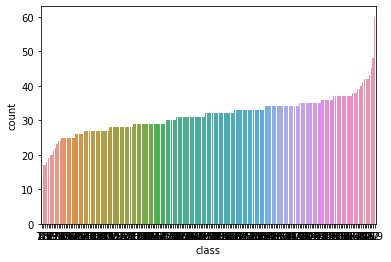

In [7]:
if True:
    submission = pd.read_csv(inputdir+'sample_submission.csv')
    submission["class"] = final_pred  
    submission.to_csv("submission.csv", index=False)
    submission.head()

# In[17]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)

In [24]:
if False:
    dfpredictions = pd.DataFrame(np.max(final_pred, axis=1).squeeze() )
    dfpredictions.describe()
    dfpredictions[0].plot.hist(bins=20)
    psids = dfpredictions[0]>0.99 
    np.sum(psids)

In [25]:
# pseudo dataset
# x_test[psids]
# pdi[psids]
# make pseudo
if False:
    print('Create Pseudo Label')
    x_test = np.load(datadir+'x_test3.npy')
    np.save('x_pseudo3.npy', x_test[psids])
    np.save('y_pseudo3.npy', pdi[psids])